In [23]:
import numpy as np
import torch
from torch import nn  
import time 
import os  
import xarray as xr
import subprocess
import matplotlib.pyplot as plt
from get_AM4_data_lw import get_AM4_data_lw_coords

In [2]:
## import self defined functions
from sys import path 
# insert at 1, 0 is the script path (or '' in REPL)
# sys.path.insert(1, home+'/local/python_lib')
root = '/tigress/cw55/work/2022_radi_nn/NN_AM4'
path.insert(1,  root+'/work')
import work.lw_csaf_Li5Relu_cluster.train_script as lwcsaf6
import work.lw_csaf_Li5Relu_cluster_wd.train_script as lwcsaf5

In [3]:
######################################################
# common functions to split the training and test data
from NNRTMC_lw_utils import  split_train_test_sample, \
draw_batches, data_std_normalization, print_key_results, return_exp_dir
    

In [25]:
z_lev = [ 1.      ,    4.      ,    8.186021,   13.788865,   20.917952,
         29.836408,   41.217896,   55.792215,   74.201906,   97.047864,
        124.966648,  158.549553,  198.396959,  245.027221,  298.888576,
        360.040179,  427.458025,  498.243573,  568.220535,  633.836047,
        693.266329,  745.991986,  792.097373,  831.921945,  865.977814,
        894.872525,  919.22792 ,  939.565932,  956.402132,  970.147661,
        981.130665,  989.68    ,  995.9     ,  1000.     ]

In [4]:
if __name__ == '__main__': 
    torch.cuda.set_device(0) # select gpu_id, default 0 means the first GPU
    device = f'cuda:{torch.cuda.current_device()}'
    ######################################################
    # set exp name and runs
    Exp_name = ['lw_csaf_Li5Relu_cluster']
    Exp_name_model_dict = {'lw_csaf_Li5Relu_cluster': lwcsaf6}
    work_dir = root+'/work/' 
    

In [12]:
    # load data from AM4 runs
    out_filelist = [f'/scratch/gpfs/rm5768/ml/20000101.fluxes.tile{_}.nc' for _ in range(1,7)]
    inp_filelist = [f'/scratch/gpfs/rm5768/ml/20000101.new_offline_input.tile{_}.nc' for _ in range(1,7)]
    input_array_ori, output_array_ori, ds_coords = \
    get_AM4_data_lw_coords(out_filelist, inp_filelist, condition='csaf', month_sel = None, day_sel = [1]) 
    
    hybrid_p_sigma_para = xr.open_dataset('/tigress/cw55/data/NNRTMC_dataset/AM4_pk_bk_202207.nc')
    A_k = hybrid_p_sigma_para.ak.values[None,:]
    B_k = hybrid_p_sigma_para.bk.values[None,:]
    truth = output_array_ori
    

Data selection:
Month: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12] 
Day: [1]


In [7]:
predi = {}
error = {}
NN_model = {}

In [17]:
for mo in Exp_name:
    ######################################################
    # create dir for first run or load restart file
    run_num, exp_dir = return_exp_dir(work_dir, mo, create_dir=False)
    # load restart file
    PATH_last =  exp_dir+f'/restart.{run_num-1:02d}.pth'
    restart_data = torch.load(PATH_last)  # load exist results and restart training
    print(f'load: {PATH_last}')
    # read training dataset, nor_para, model parameteres
    nor_para = restart_data['nor_para']
    model_state_dict = restart_data['model_state_dict'] 
    print(f"Total data size: {input_array_ori.shape[0]}")
    # normalize data via saved nor_para in restart file
    nor_para, input_array, output_array   = data_std_normalization(input_array_ori, output_array_ori, nor_para)
    ######################################################
    # move all data to GPU to accelerate training
    input_torch = torch.tensor(input_array, dtype=torch.float32).to(device)
    output_torch = torch.tensor(output_array, dtype=torch.float32).to(device) 

load: /tigress/cw55/work/2022_radi_nn/NN_AM4/work/lw_csaf_Li5Relu_cluster/restart.04.pth
Total data size: 5308416


In [18]:
    # initialize model
    NN_model[mo] = Exp_name_model_dict[mo].ResNNRTMC(device, nor_para, A_k, B_k, model_state_dict)  

In [19]:
    predi[mo]   = NN_model[mo].predict(input_torch).cpu().numpy()
    loss_test   = NN_model[mo].test_loss(np.arange(input_torch.shape[0]), input_torch,  output_torch)
    print( f"{mo:15s} loss: V {loss_test[0]:8.2e} E {loss_test[1]:8.2e}  ")

    predi[mo] = predi[mo]/nor_para['output_scale'] + nor_para['output_offset']
    error[mo] = predi[mo] - truth
    error[mo][:,3:] = error[mo][:,3:]*86400 # HR K/s >> K/day

lw_csaf_Li5Relu_cluster loss: V 9.17e-04 E 9.69e-01  


In [20]:
for i, mo in enumerate(Exp_name):
    RMSE = ((error[mo]**2).mean(axis=0))**0.5
    MAE  = abs(error[mo]).mean(axis=0)
    bias = error[mo].mean(axis=0)
    print(MAE [:3].mean())
    print(MAE [3:].mean())

0.39560547
0.009414119


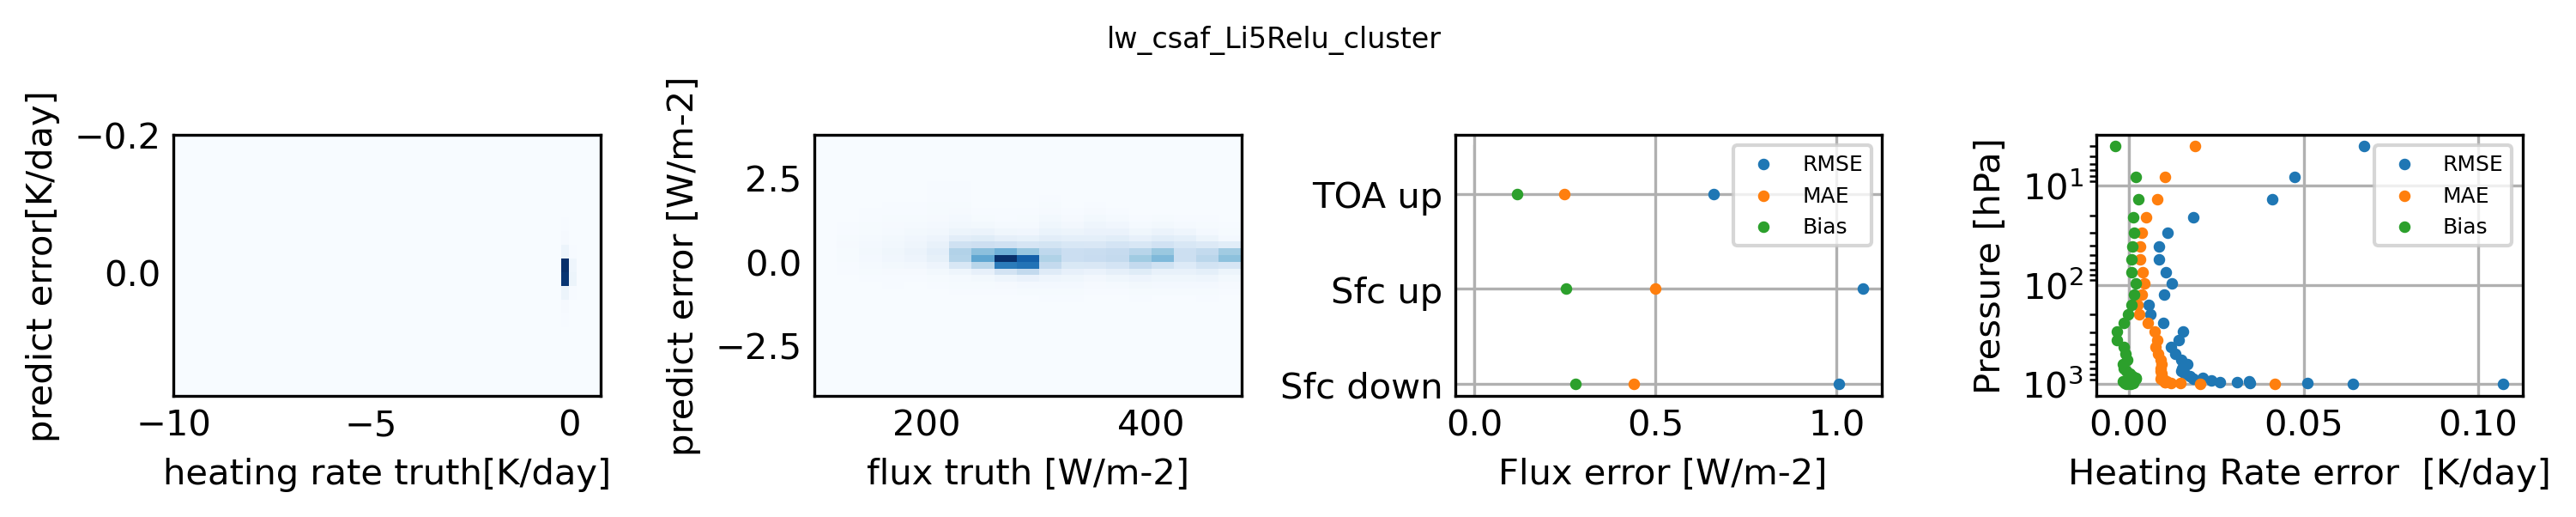

In [26]:
for i, mo in enumerate(Exp_name):
    
    RMSE = ((error[mo]**2).mean(axis=0))**0.5
    MAE  = abs(error[mo]).mean(axis=0)
    bias = error[mo].mean(axis=0)
    plt.style.use('_mpl-gallery')
    fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(10,2),dpi=300) 
    axs=axs.flatten()
    ax1=axs[0] # heating rate
    ax2=axs[1] # surface flux
    ax3=axs[2] # error
    ax4=axs[3] # error
    # ax1.scatter(truth[:,3:].flatten(), bias[:,3:].flatten() , s=1) 
    ax1.hist2d(truth[:,3:].flatten(), error[mo][:,3:].flatten(), bins=(np.arange(-10, 1, 0.2), np.arange(-0.2, 0.2, 0.02)))
    # ax2.scatter(truth[:,:3].flatten(), bias[:,:3].flatten() , s=1) 
    ax2.hist2d(truth[:,:3].flatten(), error[mo][:,:3].flatten(), bins=(np.arange(100, 500, 20), np.arange(-4, 4, 0.2)))

    ax1.invert_yaxis()
    ax1.set_xlabel('heating rate truth[K/day]')
    ax1.set_ylabel('predict error[K/day]')
    ax2.set_xlabel('flux truth [W/m-2]')
    ax2.set_ylabel('predict error [W/m-2]')

    ax3.scatter(RMSE[:3], np.arange(3),  s=5, label='RMSE')
    ax3.scatter(MAE [:3], np.arange(3),  s=5, label='MAE')
    ax3.scatter(bias[:3], np.arange(3),  s=5, label='Bias')
    ax3.plot([0,0],[0,2.5],c='k',linewidth = 0.5, zorder=0)
    ax3.set_yticks([0,1,2], labels=[ 'Sfc down','Sfc up','TOA up',])
    ax3.legend(fontsize=6)
    ax3.set_xlabel('Flux error [W/m-2] ')
#     ax3.set_xlim([-0.1,1.2])

    ax4.scatter(RMSE[3:]  , z_lev[1:],  s=5, label='RMSE')
    ax4.scatter(MAE [3:]  , z_lev[1:],  s=5, label='MAE') 
    ax4.scatter(bias[3:]  , z_lev[1:],  s=5, label='Bias')
    ax4.plot([0,0],[0,1e3],c='k',linewidth = 0.5, zorder=0)
    ax4.legend(fontsize=6)
    ax4.invert_yaxis()
    ax4.set_yscale('log') 
#     ax4.set_xlim([-0.04,0.4])
    ax4.set_xlabel('Heating Rate error  [K/day]')
    ax4.set_ylabel('Pressure [hPa]')
    plt.suptitle(mo,fontsize=8)
    fig.tight_layout()
    fig.show()

# Map